In [ ]:
import torch
from data.load_data import *


batch_size = 64
num_workers = 2
img_size = 128
num_classes_limit = 20

train_loader, val_loader, train_dataset, val_dataset = get_stanford_cars_loaders(
    num_classes_limit=num_classes_limit,
    img_size=img_size,
    batch_size=batch_size,
    num_workers=num_workers)

In [53]:
imgs, labels = next(iter(train_loader))
print("Batch shape:", imgs.shape)
print("Labels min/max:", labels.min().item(), labels.max().item())
print("Número de clases usadas:", num_classes_limit)

Batch shape: torch.Size([64, 3, 128, 128])
Labels min/max: 0 19
Número de clases usadas: 20


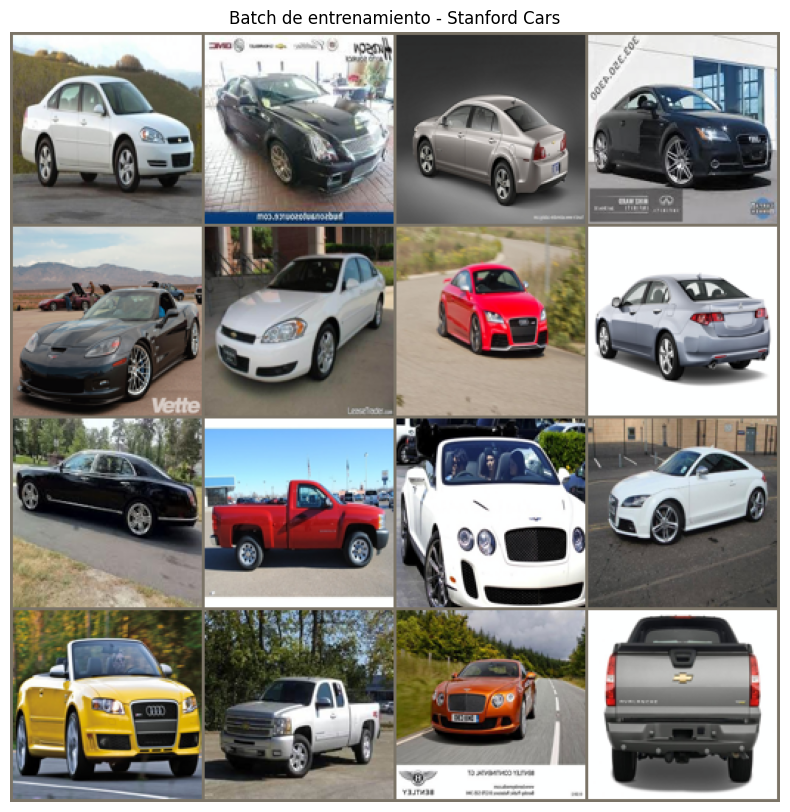

In [37]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

IMAGENET_MEAN = np.array([0.485, 0.456, 0.406])
IMAGENET_STD  = np.array([0.229, 0.224, 0.225])

def denormalize(img_tensor):
    """
    img_tensor: tensor [3, H, W]
    """
    img = img_tensor.numpy().transpose(1, 2, 0)
    img = img * IMAGENET_STD + IMAGENET_MEAN
    img = np.clip(img, 0, 1)
    return img

imgs, labels = next(iter(train_loader))
grid = torchvision.utils.make_grid(imgs[:16], nrow=4)
grid_np = denormalize(grid)
plt.figure(figsize=(10, 10))
plt.imshow(grid_np)
plt.axis("off")
plt.title("Batch de entrenamiento - Stanford Cars")
plt.show()


# Model

In [ ]:
from model.mobiel_net_block import *

In [12]:

  x = torch.randn(4, 32, 112, 112)
  b_v1 = MobileNetBlock(32, 64, stride=2, version="v1")
  y_v1 = b_v1(x)
  print("v1:", y_v1.shape)  # [4, 64, 56, 56]

  # v2: inverted residual con expansión 6
  b_v2 = MobileNetBlock(32, 32, stride=1, version="v2", expand_ratio=6)
  y_v2 = b_v2(x)
  print("v2 (residual):", y_v2.shape)  # [4, 32, 112, 112]

  # v2 con cambio de canales (no hay skip)
  b_v2_nc = MobileNetBlock(32, 64, stride=2, version="v2", expand_ratio=6)
  y_v2_nc = b_v2_nc(x)
  print("v2 (no residual):", y_v2_nc.shape)  # [4, 64, 56, 56]


v1: torch.Size([4, 64, 56, 56])
v2 (residual): torch.Size([4, 32, 112, 112])
v2 (no residual): torch.Size([4, 64, 56, 56])


In [ ]:
from model.mobielnet import *

num_classes = 196
mobilenet_v1 = MobileNet(num_classes=num_classes, version="v1", width_mult=1.0)
mobilenet_v2 = MobileNet(num_classes=num_classes, version="v2", width_mult=1.0)

imgs, labels = next(iter(train_loader))
print("Input batch shape:", imgs.shape)

with torch.no_grad():
    out_v1 = mobilenet_v1(imgs)
    out_v2 = mobilenet_v2(imgs)

print("Output MobileNetV1:", out_v1.shape)  # [B, 196]
print("Output MobileNetV2:", out_v2.shape)  # [B, 196]

params_v1 = count_params(mobilenet_v1)
params_v2 = count_params(mobilenet_v2)

print(f"MobileNetV1 (α=1.0, {num_classes} clases): {params_v1:,} parámetros")
print(f"MobileNetV2 (α=1.0, {num_classes} clases): {params_v2:,} parámetros")
print(f"Ratio V2/V1: {params_v2/params_v1:.3f}")

Input batch shape: torch.Size([64, 3, 128, 128])
Output MobileNetV1: torch.Size([64, 196])
Output MobileNetV2: torch.Size([64, 196])
MobileNetV1 (α=1.0, 196 clases): 3,407,876 parámetros
MobileNetV2 (α=1.0, 196 clases): 2,474,948 parámetros
Ratio V2/V1: 0.726


---
# Training

In [ ]:
from training.training import *

In [ ]:
device = get_device()
print("Device:", device)
num_classes = 100

net1_layers_tiny = [
    (32,   1),
    (64,   2),
    (64,   1),
    (128,  2),
    (128,  1),
    (256,  2),
    (256,  1),
]

model = MobileNet(
    num_classes=num_classes,
    version="v1",
    width_mult=1,
    drop_out_rate=0.2,
    net1_layers=net1_layers_tiny)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3 ,weight_decay=1e-4)

diffaug = DiffAugment(p_flip=0.5, p_brightness=0.5,
                      max_brightness_delta=0.2, p_contrast=0.5,
                      max_contrast_scale=0.2, p_cutout=0.5, cutout_frac=0.25)
acc_targets = (0.88, 0.94)

model, history = train_mobilenet(model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    device=device,
    criterion=criterion,
    diff_augment=diffaug,
    num_epochs=50, patience=5,
    early_stop_delta=1e-3,
    acc_targets=acc_targets,verbose=True)

In [ ]:
device = get_device()
print("Device:", device)
num_classes = 20

net2_layers_tiny = [
    # t,  c,   n,  s
    [1,  16,  1,  1],  # bloque inicial pequeño
    [6,  24,  2,  2],  # downsample 1
    [6,  32,  2,  2],  # downsample 2
    [6,  64,  2,  2],  # downsample 3 (último)
]


model_2 = MobileNet(num_classes=num_classes, version="v2", width_mult=0.8, drop_out_rate= 0.3 , net2_layers=net2_layers_tiny)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_2.parameters(), lr=1e-3)
diffaug = DiffAugment(p_flip=0.5, p_brightness=0.5,
                      max_brightness_delta=0.2, p_contrast=0.5,
                      max_contrast_scale=0.2, p_cutout=0.5, cutout_frac=0.25)

acc_targets = (0.88, 0.94)

model_2, history = train_mobilenet(model=model_2,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    device=device,
    criterion=criterion,
    diff_augment=diffaug,
    num_epochs=50, patience=5,
    early_stop_delta=1e-3,
    acc_targets=acc_targets,verbose=True)

---

## **Pablo Reyes**
